# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), și [sounddevice](https://python-sounddevice.readthedocs.io/).

In [1]:
# Horjea Cosmin-Marian, 343
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

# Generarea unui semnal sinusoidal

Întâi trebuie să definim parametrii sinusoidei continuue:

* orizontul de timp ($t$)
* frecvența semnalului original ($f_0$)
* amplitudinea ($A$)
* faza ($\varphi$)

In [2]:
time_of_view = 1     # s
frequency = 2        # Hz
amplitude = 1
phase = 0

Iar apoi parametrii de măsurare, sinusoida discretizată:
* frecvența de eșantionare ($f_s$)
* perioada de eșantionare ($t_s$)
* numărul de eșantionare ($n$)

In [3]:
sampling_rate = 12    # Hz
sampling_period = 1./sampling_rate  # s
n_samples = time_of_view/sampling_period

Cu datele de mai sus putem genera orizontul de timp cu momentele de interes pentru semnalul continuu și cel discretizat ($t$, respectiv $nt_s$):

In [4]:
atime = np.linspace (0, time_of_view, int(10e5 + 1)) # s.
time = np.linspace (0, time_of_view, int(n_samples + 1))

*Observație*: orizontul de timp continuu (analog) este de fapt un orizont de timp discret ($nt_s$) foarte dens ($n=10^5$ eșantione).

Cu aceste date putem crea o funcție sinus ce generează sinusoidele parametrizate conform variabilelor de mai sus:

In [5]:
def sine (amplitude, frequency, time, phase):
    return amplitude * np.sin (2 * np.pi * frequency * time + phase)

## Sinusoidă continuă
Pentru a obține o sinusoidă "continuă" putem apela funcția ```sine```:

In [6]:
asignal = sine(amplitude, frequency, atime, phase)

plt.grid(True)
plt.plot (atime, asignal)

## Sinusoidă discretizată
Discretizarea se obține apelând aceiași funcție ```sine``` dar cu parametrii discreți și folosind ```stem``` pentru a obține cele $n$ eșantioane:

<StemContainer object of 3 artists>

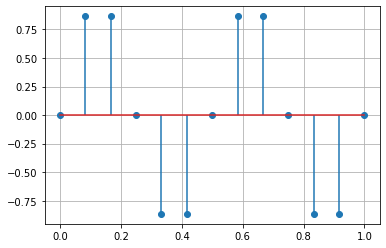

In [7]:
signal = sine(amplitude, frequency, time, phase)

plt.grid(True)
plt.stem (time, signal)

# Producerea și audiția unui ton

Pentru a produce o sinusoidă ce poate fi percepută de urechea umană trebuie să creștem frecvența și amplitudinea acesteia.

În exemplul de mai jos generăm o sinusoidă de frecvență $f_0=440\text{Hz}$ și amplitudine $10.000$ pe care o discretizăm cu frecvența de eșantionare $f_s=44.100\text{Hz}$ pe un orizont de timp de $2\text{s}$.

In [8]:
time_of_view = 2     # s
frequency = 440      # Hz
amplitude = 1000
phase = 0

sampling_rate = 44100
sampling_period = 1./sampling_rate  # s
n_samples = time_of_view/sampling_period
time = np.linspace (0, time_of_view, int(n_samples + 1))

tone = sine(amplitude, frequency, time, phase)

Aceast ton îl vom discretiza cu o frecvență de eșantionare $f_s$ conform ```sampling_rate``` și îl vom transforma în formatul WAV prin conversia eșantioanelor la întregi pe 16-biți:

In [9]:
sd.default.samplerate = sampling_rate
wav_wave = np.array(tone, dtype=np.int16)
sd.play(wav_wave, blocking=True)
sd.stop()

# Sarcini

1. [8p] Scrieți tonurile pentru notele muzicale Do, Re, Mi, Fa, Sol, La, Si, Do.

2. [8p] Compuneți un cântec simplu clasic (ex. Frère Jacques) într-un singur semnal.

3. [4p] Citiți o partitură la intrare (folosind [LilyPond](https://lilypond.org/) sau formatul propriu) și produceți semnalul ce conține melodia la ieșire prin compunerea tonurilor asociate notelor automat.

In [10]:
# 1.

# Creem un ton in functie de o frecventa data
def make_tone(freq,seconds=0.25):
    time_of_view = seconds
    frequency = freq
    amplitude = 1000
    phase = 0

    sampling_rate = 44100
    sampling_period = 1./sampling_rate
    n_samples = time_of_view/sampling_period
    time = np.linspace (0, time_of_view, int(n_samples + 1))
    return sine(amplitude, frequency, time, phase)


In [11]:
# am scris direct tonurile pentru scara clasica, aproximativ
note_muzicale = [440,493,523,587,660,700,738,880]
for nota_freq in note_muzicale:
    wav_wave = np.array(make_tone(nota_freq,0.3), dtype=np.int16)
    sd.play(wav_wave, blocking=True)
    sd.stop()

In [12]:
#2. 
#modificam array-ul de note muzicale astfel incat sa avem label-ul cheii
note_muzicale = {
    ' ':0,
    'A':440,
    'A#':466,
    'B':493,
    'C':523,
    'C#':554,
    'D':587,
    'D#':622,
    'E':660,
    'F':700,
    'F#':741,
    'G':784,
    'G#':830,
    'A':880
}
# putem sa punem totate notele in oridine intr-un array(string) iar dupa aceea sa generam pe rand tonuri
melodie = "CDECCDEC EFGEFG GAGFECGAGFEC CGCCGC"
#spatiile goale genereaza o pauza

# acum creem tonuri si le combinam intr-un singur array
tonuri = []
for m in list(melodie):
    tonuri.append(make_tone(note_muzicale[m],0.4))

tonuri = np.concatenate(tonuri)


wav_wave = np.array(tonuri, dtype=np.int16)
sd.play(wav_wave, blocking=True)
sd.stop()

3.

Pornind de la specificatia LilyPons(https://lilypond.org/text-input.html) , putem sa interpretam un text ceva mai simplu

c4 c g g a a g2 , unde literele sunt notele iar cifrele sunt duratele

eis - unde -is vine de la "sharp" -> e#

e4is - si *nu* eis4


In [20]:
# 3.
def parse_note(nota):
    label = nota[0].upper()
    time = 1
    if(len(nota)>1 and nota[1].isdigit()):
        time = int(nota[1])
    if nota.endswith("is"):
        label+="#"
    return (label,time)


def get_melody_from_file(filename):
    global note_muzicale
    with open(filename) as f:
        melodie = [(line.strip().split(' ')) for line in f.readlines()]
    tones = []
    for m in melodie:
        for nota in m:
            (label,time) = parse_note(nota)
            tones.append(make_tone(note_muzicale[label],time/4))
    tones = np.concatenate(tones)
    return tones


In [21]:
# print(get_melody_from_file("melodie.txt"))
wav_wave = np.array(get_melody_from_file('melodie.txt'), dtype=np.int16)
sd.play(wav_wave, blocking=True)
sd.stop()